## Plot 2 project


In [25]:
import pandas as pd
import datetime as dt

# Function to load a CSV file
def load_csv_file(file_path):
    """Loads a CSV file into a pandas DataFrame and returns it."""
    try:
        df = pd.read_csv(file_path)
        # print(f"Successfully loaded '{file_path}'. Head of the DataFrame:")
        # print(df.head())
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the path.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")
        return None

In [36]:
# load the data 
data = load_csv_file("data/final_data.csv")
data.head(10)

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill,relative_availability
0,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00,4,0,NaN
1,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00,1,0,NaN
2,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00,1,0,NaN
3,2016-04-12 13:00:00,6,NaN,NaN,NaN,NaN,21,"Ammerbau, Ebene 4, Links",42,08:00:00,00:00:00,1,0,NaN
4,2016-04-12 13:00:00,7,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 4, Mitte",27,08:00:00,00:00:00,1,0,NaN
5,2016-04-12 13:00:00,9,NaN,NaN,NaN,NaN,8,"Ammerbau, Ebene 5, Links",27,08:00:00,00:00:00,1,0,NaN
6,2016-04-12 13:00:00,10,NaN,NaN,NaN,NaN,15,"Ammerbau, Ebene 5, Mitte",29,08:00:00,00:00:00,1,0,NaN
7,2016-04-12 13:00:00,11,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 5, Rechts",27,08:00:00,00:00:00,1,0,NaN
8,2016-04-12 13:00:00,12,NaN,NaN,NaN,NaN,8,"Ammerbau, Ebene 6, Links",33,08:00:00,00:00:00,1,0,NaN
9,2016-04-12 13:00:00,13,NaN,NaN,NaN,NaN,12,"Ammerbau, Ebene 6, Mitte",35,08:00:00,00:00:00,1,0,NaN


In [28]:


# Ensure datetime
data["t10"] = pd.to_datetime(data["t10"])

# Extract ISO year and week
iso = data["t10"].dt.isocalendar()
data["iso_year"] = iso.year
data["iso_week"] = iso.week
data["weekday"] = data["t10"].dt.weekday


In [29]:
# taking the iso calendar weeks because of better comparison 
# excluding 6th january and everything before 
after_jan6 = ~(
    (data["t10"].dt.month == 1) &
    (data["t10"].dt.day <= 6)
)


In [30]:

# periods
winter_exam_phase = data[after_jan6 & data["iso_week"].between(2, 12)].copy()
summer_exam_phase = data[data["iso_week"].between(25, 34)].copy()


In [38]:
avg_winter = (
    winter_exam_phase.groupby(["location_id", "iso_week", "weekday", "building_id"], as_index=False)["relative_availability"]
      .mean()
)
avg_summer = (
    summer_exam_phase.groupby(["location_id", "iso_week", "weekday", "building_id"], as_index=False)["relative_availability"]
      .mean()
)


In [39]:
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

def add_xlabels(avg_df):
    avg_df = avg_df.copy()
    avg_df["x_order"] = (avg_df["iso_week"] * 10) + avg_df["weekday"]  # sortable key
    avg_df["x_label"] = (
        "W" + avg_df["iso_week"].astype(str).str.zfill(2) + " " +
        avg_df["weekday"].map(lambda d: weekday_labels[d])
    )
    avg_df = avg_df.sort_values(["x_order"])
    # make x_label an ordered category so matplotlib keeps the order
    cat_order = avg_df.drop_duplicates("x_order").sort_values("x_order")["x_label"]
    avg_df["x_label"] = pd.Categorical(avg_df["x_label"], categories=cat_order, ordered=True)
    return avg_df

avg_p1 = add_xlabels(avg_winter)
avg_p2 = add_xlabels(avg_summer)


In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# base colormap for buildings
base_cmap = plt.get_cmap("tab10")

# unique buildings
buildings = sorted(avg_p1["building_id"].unique())

# assign one base color per building
building_colors = {
    b: base_cmap(i % base_cmap.N)
    for i, b in enumerate(buildings)
}

In [44]:
def get_shades(base_color, n):
    """Return n shades of a base color"""
    base_rgb = np.array(mcolors.to_rgb(base_color))
    factors = np.linspace(0.5, 1.0, n)  # darker → lighter
    return [tuple(base_rgb * f) for f in factors]

In [45]:
location_color = {}

for b in buildings:
    locs = sorted(
        avg_p1.loc[avg_p1["building_id"] == b, "location_id"].unique()
    )
    shades = get_shades(building_colors[b], len(locs))
    for loc, col in zip(locs, shades):
        location_color[loc] = col

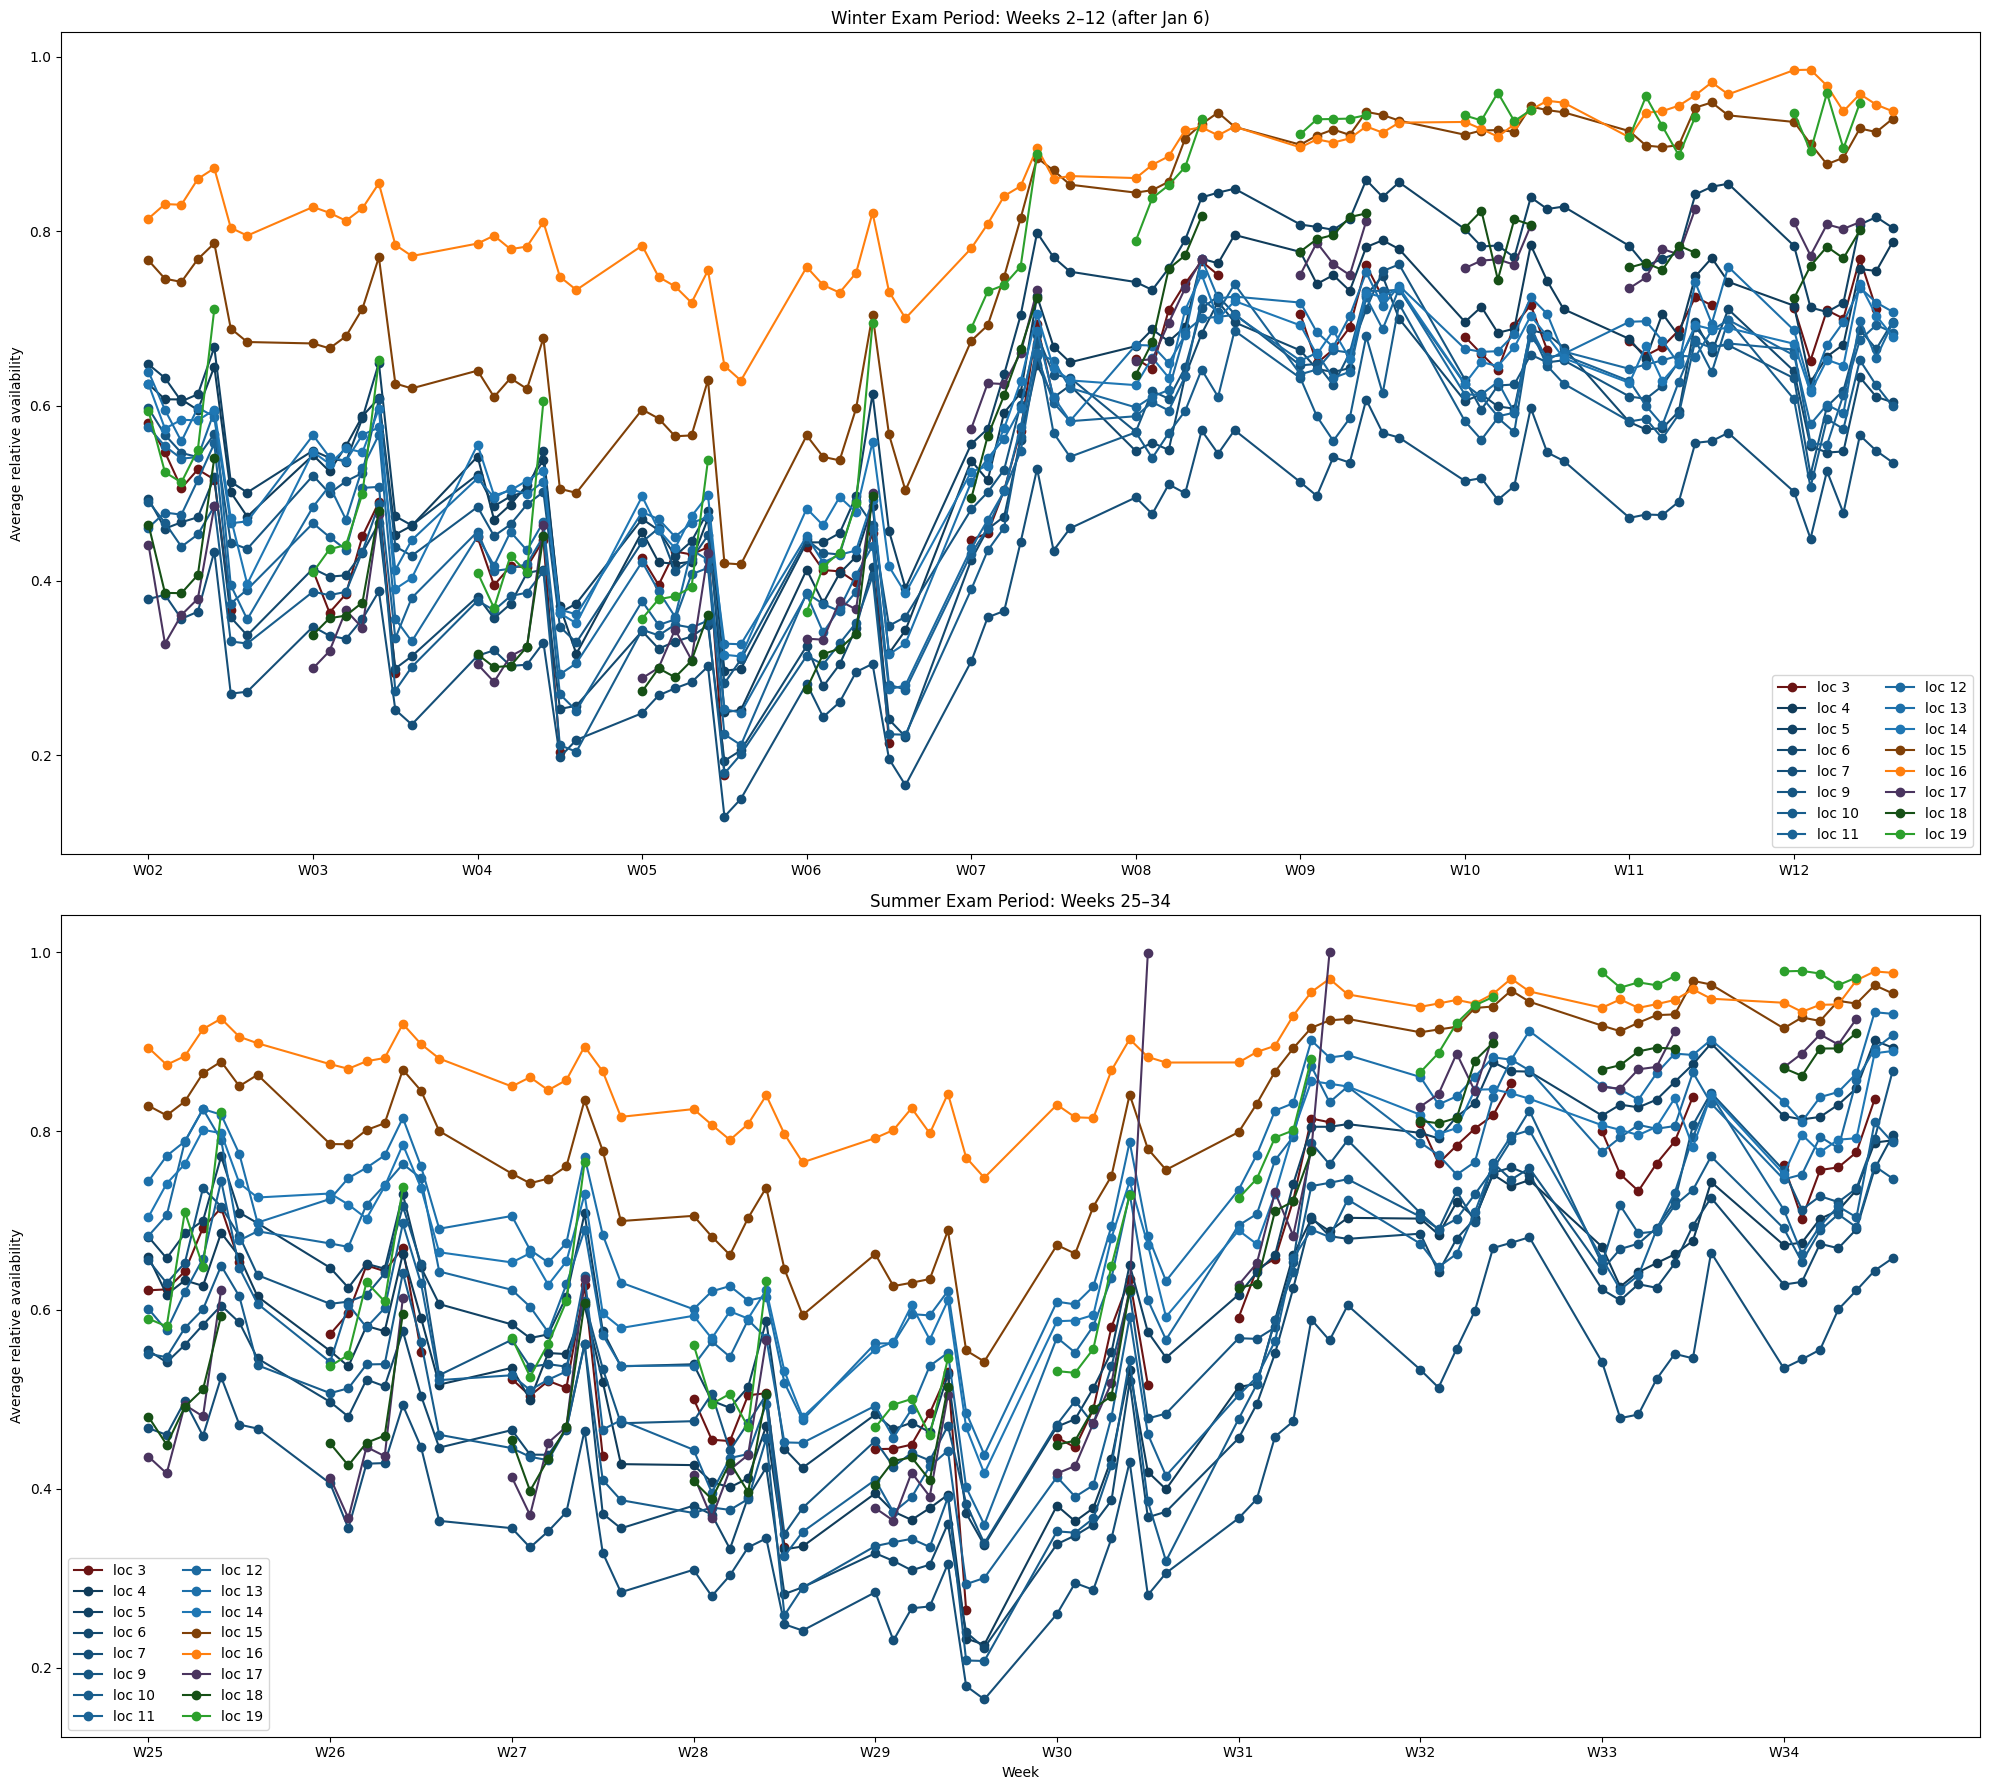

In [50]:


fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(20, 18))

# --------------------
# Period 1
# --------------------
ax = axes[0]
for loc, d in avg_p1.groupby("location_id"):
    d = d.sort_values("x_order")
    ax.plot(
        d["x_order"],
        d["relative_availability"],
        marker="o",
        color=location_color[loc],
        label=f"loc {loc}"
    )

week_starts = (
    avg_p1[avg_p1["weekday"] == 0]
    .sort_values("x_order")
    .drop_duplicates("iso_week")
)

ax.set_xticks(week_starts["x_order"])
ax.set_xticklabels([f"W{w:02d}" for w in week_starts["iso_week"]], rotation=0)

ax.set_title("Winter Exam Period: Weeks 2–12 (after Jan 6)")
ax.set_ylabel("Average relative availability")
ax.legend(ncol=2)

# --------------------
# Period 2
# --------------------
ax = axes[1]
for loc, d in avg_p2.groupby("location_id"):
    d = d.sort_values("x_order")
    ax.plot(
        d["x_order"],
        d["relative_availability"],
        marker="o",
        color=location_color[loc],
        label=f"loc {loc}"
    )

week_starts = (
    avg_p2[avg_p2["weekday"] == 0]
    .sort_values("x_order")
    .drop_duplicates("iso_week")
)

ax.set_xticks(week_starts["x_order"])
ax.set_xticklabels([f"W{w:02d}" for w in week_starts["iso_week"]], rotation=0)

ax.set_title("Summer Exam Period: Weeks 25–34")
ax.set_xlabel("Week")
ax.set_ylabel("Average relative availability")
ax.legend(ncol=2)

plt.tight_layout()
plt.show()


## plot buildings over exam period

In [51]:
building_p1 = (
    avg_p1
    .groupby(["building_id", "x_order"], as_index=False)
    .agg(
        mean_avail=("relative_availability", "mean"),
        std_avail=("relative_availability", "std"),
        n_locations=("location_id", "nunique"),
    )
)


In [52]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.get_cmap("tab10")
buildings = sorted(building_p1["building_id"].unique())

building_color = {
    b: colors(i % colors.N)
    for i, b in enumerate(buildings)
}


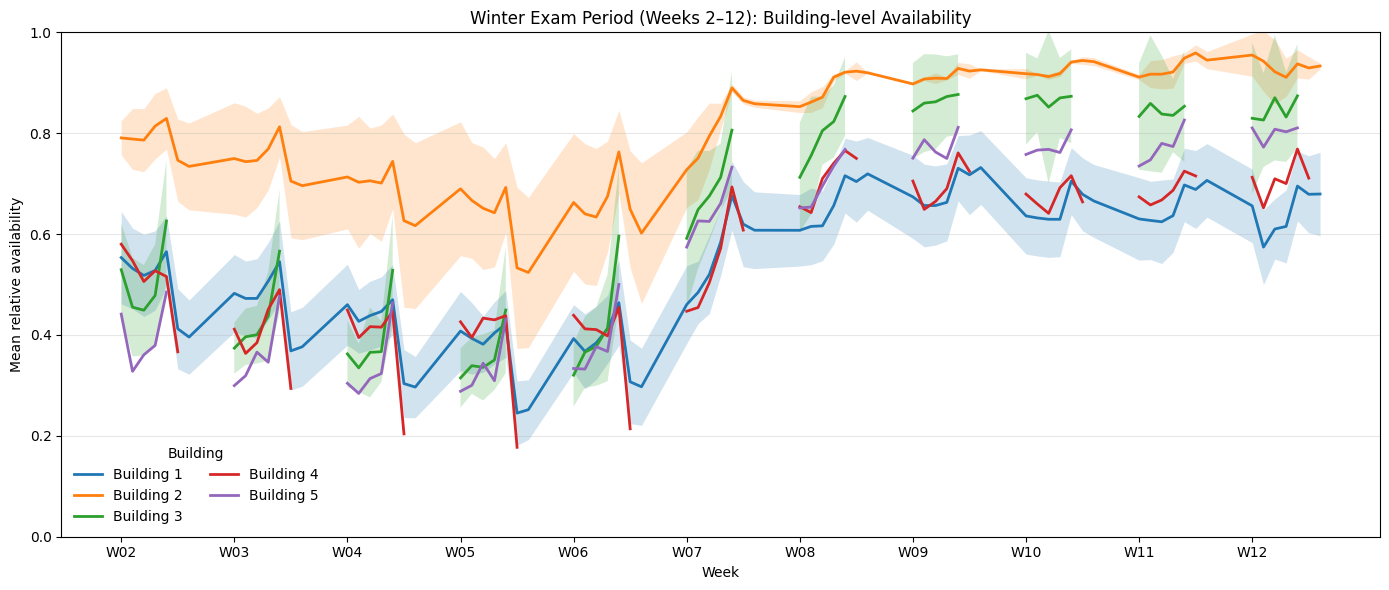

In [54]:
fig, ax = plt.subplots(figsize=(14, 6))

for b, d in building_p1.groupby("building_id"):
    d = d.sort_values("x_order")
    c = building_color[b]

    # mean line
    ax.plot(
        d["x_order"],
        d["mean_avail"],
        color=c,
        linewidth=2,
        label=f"Building {b}"
    )

    # uncertainty band (between-location variability)
    ax.fill_between(
        d["x_order"],
        d["mean_avail"] - d["std_avail"],
        d["mean_avail"] + d["std_avail"],
        color=c,
        alpha=0.2,
        linewidth=0
    )
    week_starts = (
    avg_p1[avg_p1["weekday"] == 0]
    .sort_values("x_order")
    .drop_duplicates("iso_week")
)

ax.set_xticks(week_starts["x_order"])
ax.set_xticklabels([f"W{w:02d}" for w in week_starts["iso_week"]])

ax.set_title("Winter Exam Period (Weeks 2–12): Building-level Availability")
ax.set_xlabel("Week")
ax.set_ylabel("Mean relative availability")

ax.set_ylim(0, 1)
ax.legend(title="Building", ncol=2, frameon=False)

ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()




In [55]:
avg_week_winter = (
    winter_exam_phase
    .groupby(["location_id", "building_id", "weekday"], as_index=False)
    ["relative_availability"]
    .mean()
)


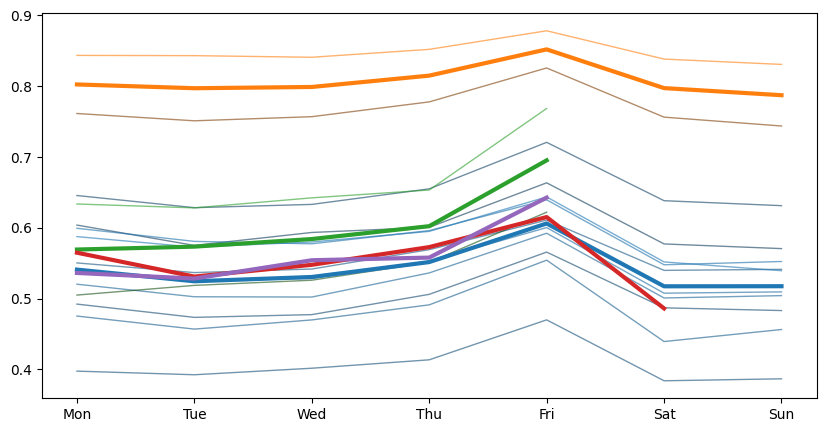

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))

for loc, d in avg_week_winter.groupby("location_id"):
    d = d.sort_values("weekday")
    ax.plot(
        d["weekday"],
        d["relative_availability"],
        color=location_color[loc],
        alpha=0.6,
        linewidth=1
    )
ax.set_xticks(range(7))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

building_week = (
    avg_week_winter
    .groupby(["building_id", "weekday"], as_index=False)
    ["relative_availability"]
    .mean()
)

for b, d in building_week.groupby("building_id"):
    d = d.sort_values("weekday")
    ax.plot(
        d["weekday"],
        d["relative_availability"],
        linewidth=3,
        label=f"Building {b}"
    )


In [57]:
df_winter = winter_exam_phase.copy()
df_summer = summer_exam_phase.copy()



In [59]:
df_winter["weekday"] = df_winter["t10"].dt.weekday      # 0=Mon … 6=Sun
df_winter["hour"] = df_winter["t10"].dt.hour

In [61]:
loc_week = (
    df_winter
    .groupby(["location_id", "building_id", "weekday", "hour"], as_index=False)
    ["relative_availability"]
    .mean()
)


In [63]:
building_week = (
    loc_week
    .groupby(["building_id", "weekday", "hour"], as_index=False)
    .agg(
        mean_avail=("relative_availability", "mean"),
        std_avail=("relative_availability", "std"),
        n_locations=("location_id", "nunique"),
    )
)


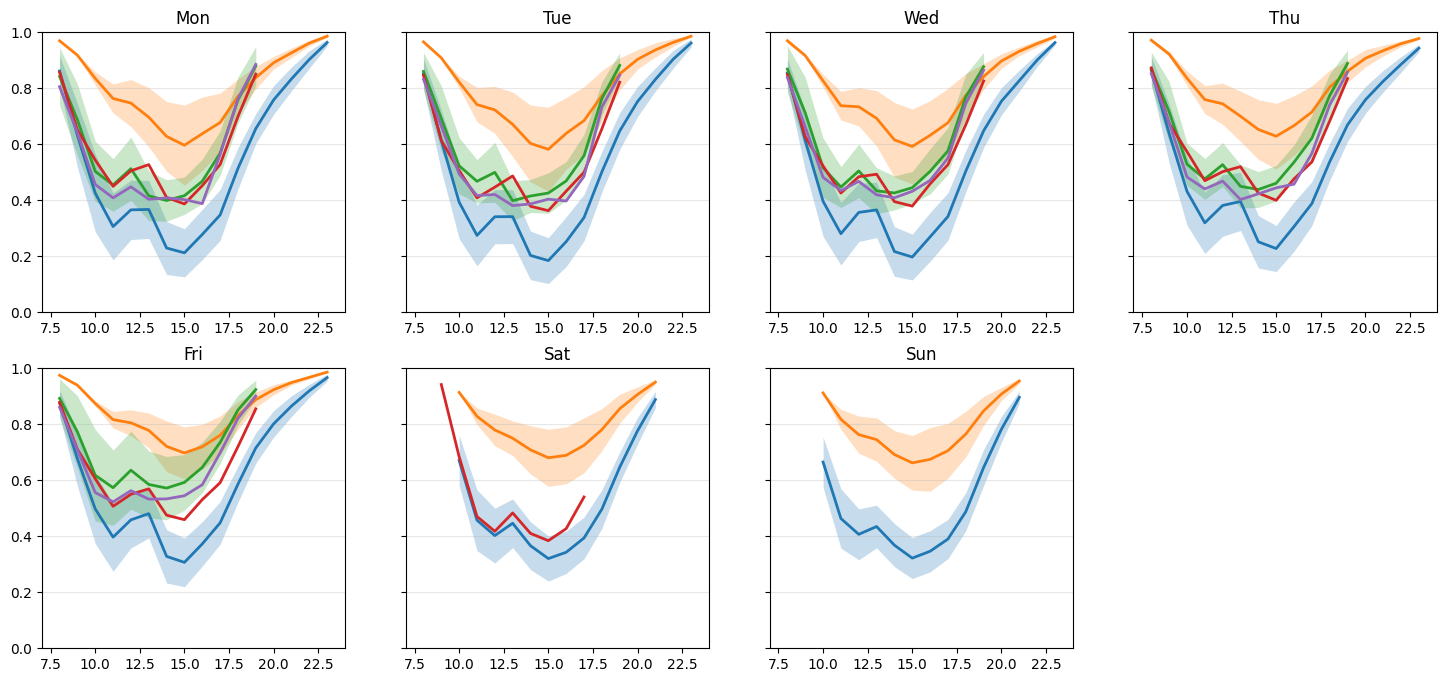

In [66]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=2, ncols=4,
    figsize=(18, 8),
    sharey=True,
)

axes = axes.flatten()
weekday_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

colors = plt.get_cmap("tab10")
buildings = sorted(building_week["building_id"].unique())

building_color = {
    b: colors(i % colors.N)
    for i, b in enumerate(buildings)
}

for wd in range(7):
    ax = axes[wd]
    day_data = building_week[building_week["weekday"] == wd]

    for b, d in day_data.groupby("building_id"):
        d = d.sort_values("hour")
        c = building_color[b]

        ax.plot(
            d["hour"],
            d["mean_avail"],
            color=c,
            linewidth=2,
            label=f"Building {b}"
        )

        ax.fill_between(
            d["hour"],
            d["mean_avail"] - d["std_avail"],
            d["mean_avail"] + d["std_avail"],
            color=c,
            alpha=0.25,
            linewidth=0
        )

    ax.set_title(weekday_names[wd])
    ax.set_xlim(7, 24)   # adapt to opening hours
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)

    axes[-1].axis("off")
    

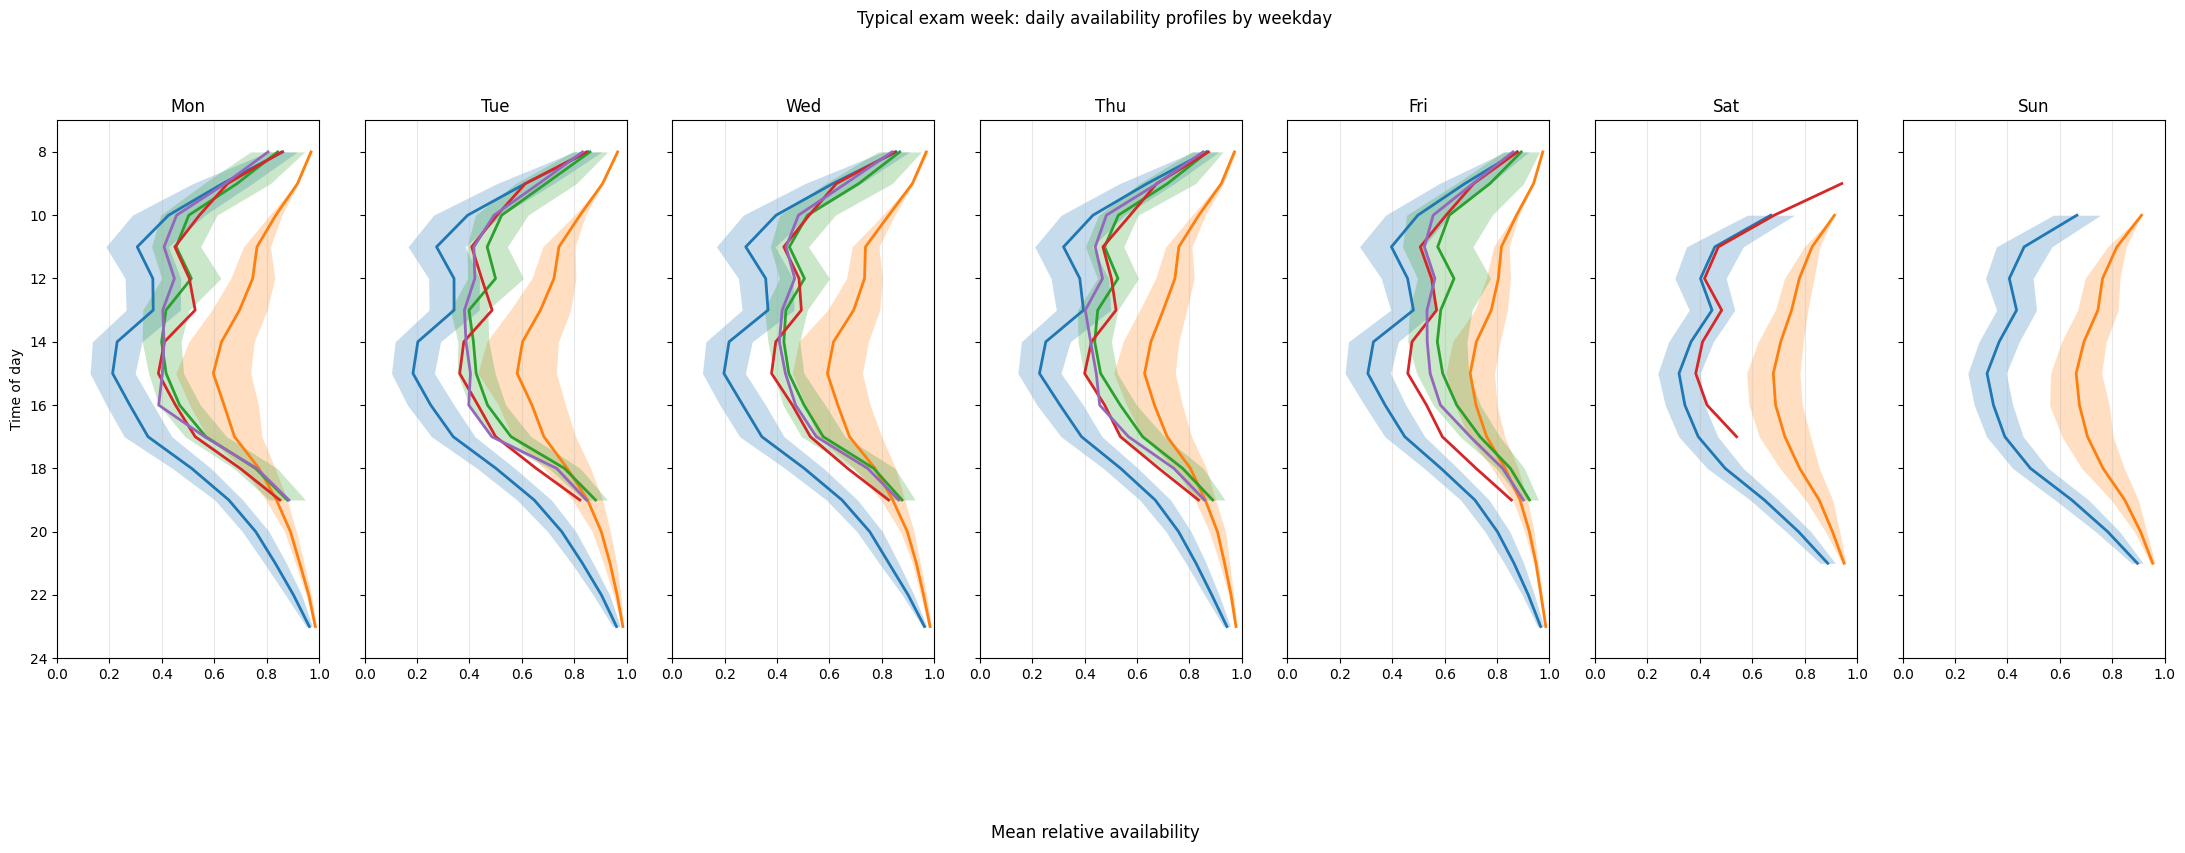

In [73]:
fig, axes = plt.subplots(
    nrows=1, ncols=7,
    figsize=(22, 8),
    sharey=True
)

weekday_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for wd in range(7):
    ax = axes[wd]
    day_data = building_week[
        building_week["weekday"] == wd
    ]

    for b, d in day_data.groupby("building_id"):
        d = d.sort_values("hour")
        c = building_color[b]

        # ---- mean line (availability on x, time on y) ----
        ax.plot(
            d["mean_avail"],
            d["hour"],
            color=c,
            linewidth=2
        )

        # ---- uncertainty band (horizontal!) ----
        ax.fill_betweenx(
            d["hour"],
            d["mean_avail"] - d["std_avail"],
            d["mean_avail"] + d["std_avail"],
            color=c,
            alpha=0.25,
            linewidth=0
        )

    ax.set_title(weekday_names[wd])
    ax.set_xlim(0, 1)
    ax.set_ylim(7, 24)   # adapt to opening hours
    ax.invert_yaxis()    # morning at top, evening at bottom (optional)
    ax.grid(axis="x", alpha=0.3)

axes[0].set_ylabel("Time of day")

fig.supxlabel("Mean relative availability")

# One legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=len(building_color),
    frameon=False
)

fig.suptitle(
    "Typical exam week: daily availability profiles by weekday",
    y=1.05
)

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()


In [74]:
building_weekday = (
    avg_week_winter
    .groupby(["building_id", "weekday"], as_index=False)
    .agg(
        mean_avail=("relative_availability", "mean"),
        std_avail=("relative_availability", "std"),
        n_locations=("location_id", "nunique"),
    )
)

def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)


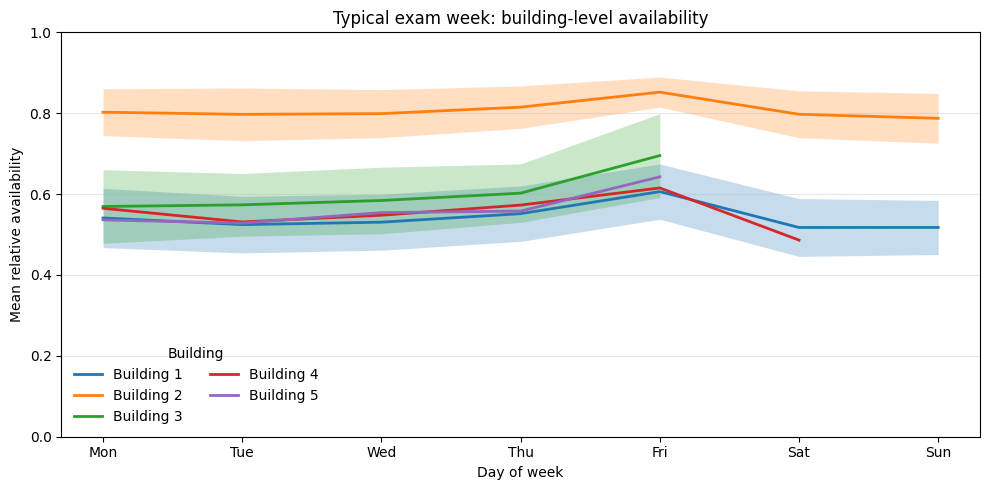

In [75]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

weekday_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
colors = plt.get_cmap("tab10")

buildings = sorted(building_weekday["building_id"].unique())
building_color = {
    b: colors(i % colors.N)
    for i, b in enumerate(buildings)
}

for b, d in building_weekday.groupby("building_id"):
    d = d.sort_values("weekday")
    c = building_color[b]

    # mean line
    ax.plot(
        d["weekday"],
        d["mean_avail"],
        color=c,
        linewidth=2,
        label=f"Building {b}"
    )

    # uncertainty band (across locations)
    ax.fill_between(
        d["weekday"],
        d["mean_avail"] - d["std_avail"],
        d["mean_avail"] + d["std_avail"],
        color=c,
        alpha=0.25,
        linewidth=0
    )
ax.set_xticks(range(7))
ax.set_xticklabels(weekday_names)

ax.set_ylim(0, 1)
ax.set_ylabel("Mean relative availability")
ax.set_xlabel("Day of week")

ax.set_title("Typical exam week: building-level availability")

ax.legend(title="Building", frameon=False, ncol=2)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


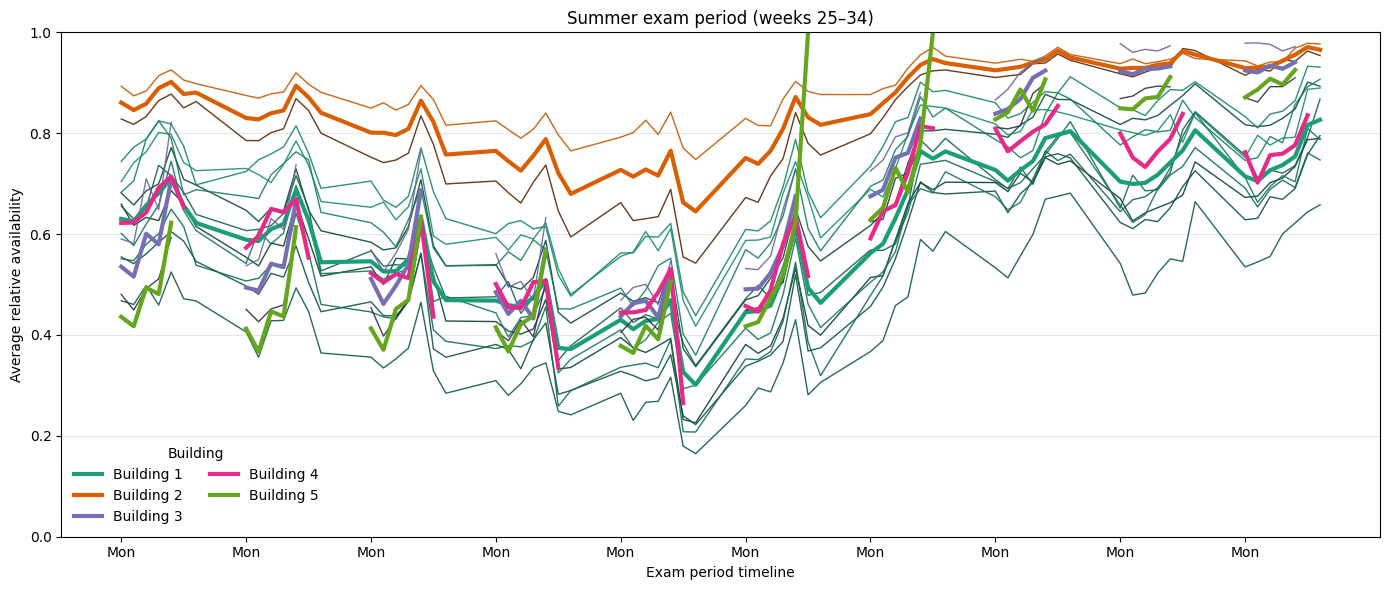

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors


# base colormap for buildings (color-blind safe)
base_cmap = plt.get_cmap("Dark2")

buildings = sorted(avg_p2["building_id"].unique())

building_base_color = {
    b: base_cmap(i % base_cmap.N)
    for i, b in enumerate(buildings)
}

def make_shades(color, n):
    rgb = np.array(mcolors.to_rgb(color))
    factors = np.linspace(0.4, 0.9, n)   # darker → lighter
    return [tuple(rgb * f) for f in factors]



fig, ax = plt.subplots(figsize=(14, 6))

for b in buildings:
    data_b = avg_p2[avg_p2["building_id"] == b]

    locs = sorted(data_b["location_id"].unique())
    shades = make_shades(building_base_color[b], len(locs))

    # ---- plot all locations (thin, no markers) ----
    for loc, c in zip(locs, shades):
        d = data_b[data_b["location_id"] == loc].sort_values("x_order")
        ax.plot(
            d["x_order"],
            d["relative_availability"],
            color=c,
            linewidth=1,
            alpha=0.9
        )

    # ---- building mean (thick line) ----
    mean_b = (
        data_b
        .groupby("x_order", as_index=False)["relative_availability"]
        .mean()
        .sort_values("x_order")
    )

    ax.plot(
        mean_b["x_order"],
        mean_b["relative_availability"],
        color=building_base_color[b],
        linewidth=3,
        label=f"Building {b}"
    )
weekday_map = {
    0: "Mon", 1: "Tue", 2: "Wed",
    3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"
}

weekday_ticks = (
    avg_p2
    .loc[avg_p2["weekday"] == 0, ["x_order", "weekday"]]
    .drop_duplicates()
    .sort_values("x_order")
)

ax.set_xticks(weekday_ticks["x_order"])
ax.set_xticklabels(
    [weekday_map[w] for w in weekday_ticks["weekday"]]
)

ax.set_ylim(0, 1)
ax.set_ylabel("Average relative availability")
ax.set_xlabel("Exam period timeline")

ax.set_title("Summer exam period (weeks 25–34)")

ax.legend(title="Building", frameon=False, ncol=2)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


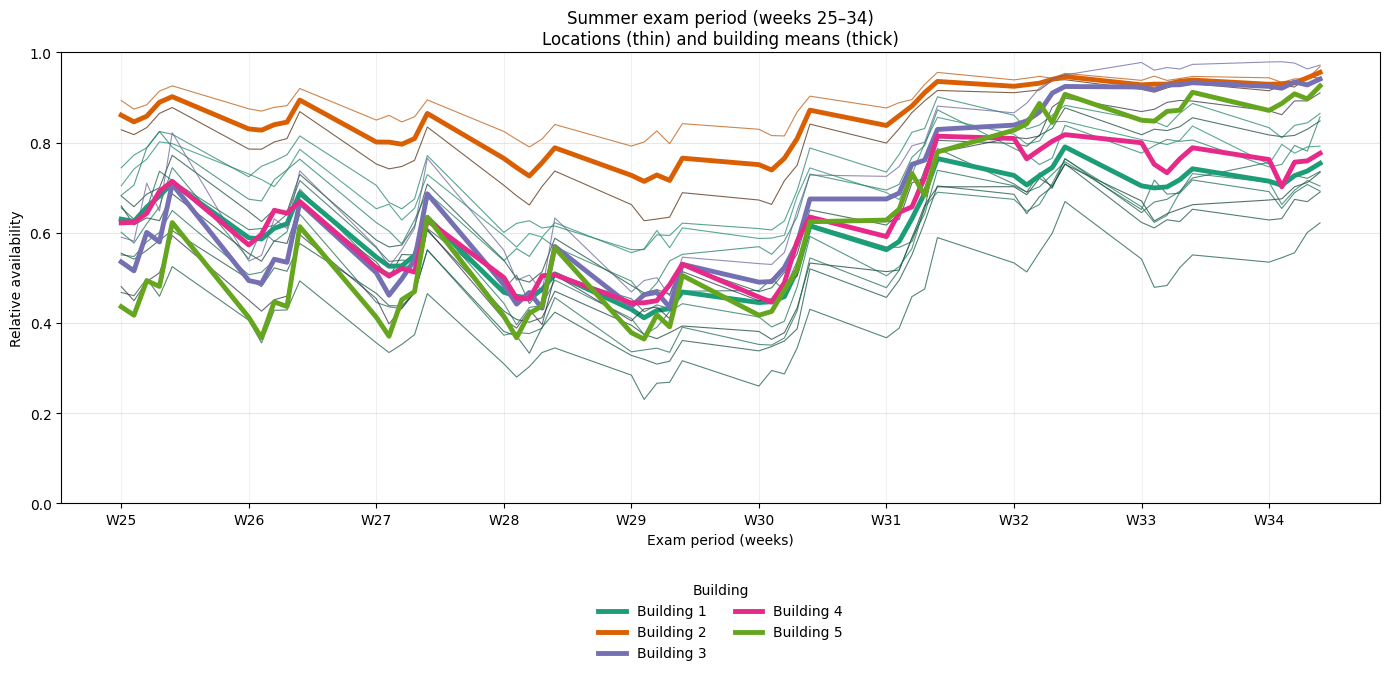

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# --------------------------------------------------
# 1. PREPARE DATA (weekdays only, BEFORE plotting)
# --------------------------------------------------

plot_data = avg_p2.copy()
plot_data = plot_data[plot_data["weekday"] < 5]   # Mon–Fri only

# --------------------------------------------------
# 2. COLOR SETUP (paper-safe)
# --------------------------------------------------

base_cmap = plt.get_cmap("Dark2")
buildings = sorted(plot_data["building_id"].unique())

building_color = {
    b: base_cmap(i % base_cmap.N)
    for i, b in enumerate(buildings)
}

def make_shades(base_color, n):
    rgb = np.array(mcolors.to_rgb(base_color))
    factors = np.linspace(0.35, 0.85, n)
    return [tuple(rgb * f) for f in factors]

# --------------------------------------------------
# 3. FIGURE
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(14, 7))

for b in buildings:
    bdata = plot_data[plot_data["building_id"] == b]

    locs = sorted(bdata["location_id"].unique())
    shades = make_shades(building_color[b], len(locs))

    # ---- locations (thin, background) ----
    for loc, c in zip(locs, shades):
        d = (
            bdata[bdata["location_id"] == loc]
            .sort_values("x_order")
        )
        ax.plot(
            d["x_order"],
            d["relative_availability"],
            color=c,
            linewidth=0.8,
            alpha=0.7
        )

    # ---- building mean (foreground) ----
    mean_b = (
        bdata
        .groupby("x_order", as_index=False)["relative_availability"]
        .mean()
        .sort_values("x_order")
    )

    ax.plot(
        mean_b["x_order"],
        mean_b["relative_availability"],
        color=building_color[b],
        linewidth=3.5,
        label=f"Building {b}"
    )

# --------------------------------------------------
# 4. X-AXIS: WEEK STRUCTURE (SUBTLE)
# --------------------------------------------------

weekday_map = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri"}

week_starts = (
    plot_data.loc[plot_data["weekday"] == 0, ["x_order", "iso_week"]]
    .drop_duplicates()
    .sort_values("x_order")
)

ax.set_xticks(week_starts["x_order"])
ax.set_xticklabels([f"W{w:02d}" for w in week_starts["iso_week"]])

# optional: faint vertical separators
for x in week_starts["x_order"]:
    ax.axvline(x, color="grey", alpha=0.15, linewidth=0.6)

# --------------------------------------------------
# 5. FINAL STYLING
# --------------------------------------------------

ax.set_ylim(0, 1)
ax.set_ylabel("Relative availability")
ax.set_xlabel("Exam period (weeks)")

ax.set_title("Summer exam period (weeks 25–34)\nLocations (thin) and building means (thick)")

ax.legend(
    title="Building",
    frameon=False,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15)
)

ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
